## Import des notebooks

L'exécution des 4 prochaines cellule dure plusieurs minutes dû à la récupération des données depuis les différentes API et l'ensemble des traitements effectués sur les DataFrame

In [2]:
%%capture 
%run BaseDélinquance.ipynb

In [3]:
%%capture 
%run BaseEclairage_v2.ipynb

In [15]:
%%capture 
%run Basevideoprotection.ipynb

In [6]:
%%capture 
%run BasePauverete.ipynb

## Réalisation de la jointure pour obtenir la base finale 

Les deux prochaines cellules unifient la nomenclature et le format de la colonne *INSEE_COG* qui servira de clé pour la jointure :

In [8]:
%run fonctions.py
delinquance_par_arrondissement['arrondissement'] = delinquance_par_arrondissement['arrondissement'].apply(extraire_arrondissement)

In [9]:
delinquance_par_arrondissement.rename(columns={"arrondissement": "INSEE_COG"}, inplace=True)


Le format de la base sur les logements sociaux implique la présence de duplicatas, nous allons donc les supprimer :

In [10]:
df_log_flt = df_log[['INSEE_COG', 'nb_log']]
df_log_flt = df_log_flt.drop_duplicates()
df_log_flt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 0 to 394
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   INSEE_COG  20 non-null     object
 1   nb_log     20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes


Nous appliquons la jointure sur des copies des bases pour éviter les avertissements de python, puis nous modifions le nom des colonnes pour que les résultats du modèle soient plus clairs :

In [16]:
import pandas as pd

df_final = df_densite[['INSEE_COG', 'densité_lum']].copy()
dataframes = [
    df_couverture_videoprotection_par_arrondissement[['INSEE_COG', 'nombre']].copy(),
    delinquance_par_arrondissement.copy(),
    df_pauv_flt[['INSEE_COG', 'TP6017']].copy(),
    df_commerces[['INSEE_COG', 'total_commerces']].copy(),
    df_log_flt.copy()
]
#Unifier le type de INSEE_COG car dans certains df il est de type int64 et dans d'autres de type object
for df in dataframes:
    df['INSEE_COG'] = df['INSEE_COG'].astype(str)
    print(f"Types after conversion: {df['INSEE_COG'].dtype}")

df_final['INSEE_COG'] = df_final['INSEE_COG'].astype(str)
print(f"Final DF type for INSEE_COG: {df_final['INSEE_COG'].dtype}")
for df in dataframes:
    df_final = pd.merge(df_final, df, on='INSEE_COG', how='inner')

df_final.head()



Types after conversion: object
Types after conversion: object
Types after conversion: object
Types after conversion: object
Types after conversion: object
Final DF type for INSEE_COG: object


,INSEE_COG,densité_lum,nombre,moyenne_annuelle,TP6017,total_commerces,nb_log
0,75105,1345.606894,30,114.030621,10.8,754,81
1,75110,1217.606244,43,204.109959,17.4,1395,218
2,75118,1395.251570,57,136.946715,21.2,1713,512
3,75107,1272.598344,45,122.549336,7.9,899,26
4,75106,1088.200642,23,146.365548,9.3,1393,48


In [12]:
##Après avoir tout rééxecuter renommer les colonnes directement dans df_final et appliquer ACP et Regression
df_final.rename(columns={"nombre": "nombre_cameras"}, inplace=True)
df_final.rename(columns={"TP6017": "taux_pauverete"}, inplace=True)
df_final.rename(columns={"nb_log": "log_sociaux"}, inplace=True)
df_final.rename(columns={"moyenne_annuelle": "taux_criminalite_pourmille"}, inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   INSEE_COG                   20 non-null     object 
 1   densité_lum                 20 non-null     float64
 2   nombre_cameras              20 non-null     int64  
 3   taux_criminalite_pourmille  20 non-null     float64
 4   taux_pauverete              20 non-null     float64
 5   total_commerces             20 non-null     int64  
 6   log_sociaux                 20 non-null     int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 1.2+ KB


## Modèle de Régression

Nous réalisons la régression du taux de criminalité sur la densité lumineuse, le nombre de caméras de surveillance, le taux de pauvereté, le nombre total des commerces et le nombre de logements sociaux :

In [13]:
import statsmodels.api as sm

X = df_final[['densité_lum', 'nombre_cameras', 'taux_pauverete', 'total_commerces', 'log_sociaux']]  # Variables explicatives
y = df_final['taux_criminalite_pourmille']  # Variable à expliquer

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     taux_criminalite_pourmille   R-squared:                       0.815
Model:                                    OLS   Adj. R-squared:                  0.749
Method:                         Least Squares   F-statistic:                     12.31
Date:                        Sun, 29 Dec 2024   Prob (F-statistic):           0.000102
Time:                                17:56:26   Log-Likelihood:                -109.55
No. Observations:                          20   AIC:                             231.1
Df Residuals:                              14   BIC:                             237.1
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -255.7986    118.882     -2.152      0.049    -510.775      -0.822
densité_lum         0.1648      0.028      5.961      0.000       0.105       0.224
nombre_cameras      0.7103      2.040      0.348      0.733      -3.664       5.085
taux_pauverete      5.6709      7.126      0.796      0.439      -9.612      20.954
total_commerces     0.1325      0.055      2.405      0.031       0.014       0.251
log_sociaux        -0.4820      0.204     -2.368      0.033      -0.919      -0.045
==============================================================================
Omnibus:                        2.694   Durbin-Watson:                   2.788
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                1.127
Skew:                           0.498   Prob(JB):                        0.569
Kurtosis:                       3.601   Cond. No.                     1.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interprétation

Cette étude, réalisée sur les arrondissements parisiens, met en lumière des corrélations intéressantes entre le taux de criminalité et divers facteurs socio-économiques et environnementaux. La densité lumineuse et le nombre total de commerces sont positivement corrélés avec le taux de criminalité, ce qui pourrait être expliqué par le fait que les zones les plus touristiques, comme le 1er arrondissement de Paris, attirent à la fois plus de commerces et une densité lumineuse plus élevée, conduisant à un taux de criminalité supérieur. Ces zones, souvent des centres d'activité intense, pourraient donc naturellement expérimenter des niveaux de criminalité plus élevés en raison de leur grande affluence. En revanche, le nombre de caméras de surveillance et le taux de pauvreté ne montrent pas de corrélation significative avec le taux de criminalité, suggérant que ces facteurs peuvent avoir des effets complexes ou indirects qui ne sont pas immédiatement apparents à travers ce modèle. Surprenamment, une augmentation du nombre de logements sociaux est associée à une diminution du taux de criminalité. Comme nous l'avons observé dans le notebook BasePauverete.ipynb sur la carte des logements sociaux, ces derniers sont principalement localisés dans des quartiers non touristiques comme le 18ème arrondissement, ce qui pourrait expliquer leur impact positif sur la sécurité des zones moins centrales. La présence d'un nombre élevé de condition dans l'analyse suggère également la possibilité de multicollinéarité, appelant à une interprétation prudente des résultats individuels des variables.

## Analyse en composantes principales (ACP)

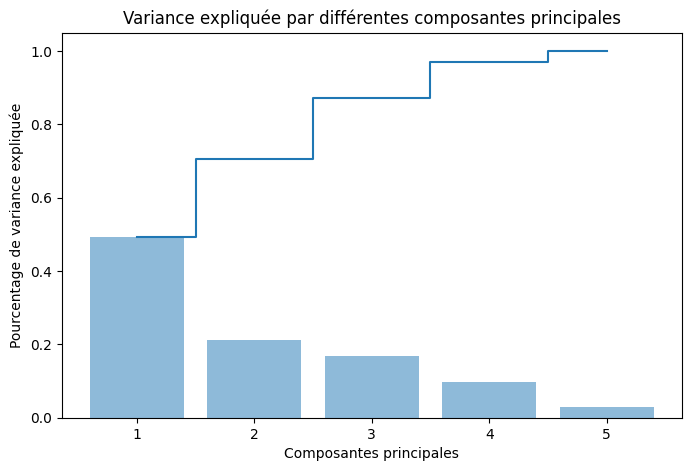

Loadings (contribution de chaque variable aux composantes) :
                      PC1       PC2       PC3       PC4       PC5
densité_lum     -0.309488  0.430101  0.797221  0.264135  0.117908
nombre_cameras   0.508107 -0.042618 -0.076658  0.850774  0.101578
taux_pauverete   0.512632  0.495649  0.094300 -0.193157 -0.667337
total_commerces  0.237312 -0.741335  0.562783 -0.097030 -0.260701
log_sociaux      0.571783  0.133981  0.181509 -0.399614  0.680056

Composante 1:
log_sociaux: 0.5718
taux_pauverete: 0.5126
nombre_cameras: 0.5081
densité_lum: 0.3095
total_commerces: 0.2373

Composante 2:
total_commerces: 0.7413
taux_pauverete: 0.4956
densité_lum: 0.4301
log_sociaux: 0.1340
nombre_cameras: 0.0426

Composante 3:
densité_lum: 0.7972
total_commerces: 0.5628
log_sociaux: 0.1815
taux_pauverete: 0.0943
nombre_cameras: 0.0767

Composante 4:
nombre_cameras: 0.8508
log_sociaux: 0.3996
densité_lum: 0.2641
taux_pauverete: 0.1932
total_commerces: 0.0970

Composante 5:
log_sociaux: 0.6801
taux_pau

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


features = ['densité_lum', 'nombre_cameras', 'taux_pauverete', 'total_commerces', 'log_sociaux']
X = df_final[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Pourcentage de variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Variance expliquée par différentes composantes principales')
plt.show()

print("Loadings (contribution de chaque variable aux composantes) :")
loadings = pd.DataFrame(pca.components_.T, columns=['PC' + str(i) for i in range(1, len(features) + 1)], index=features)
print(loadings)
for i in range(len(pca.components_)):
    print(f"\nComposante {i+1}:")
    component = pca.components_[i]
    contributions = {features[j]: abs(component[j]) for j in range(len(features))}
    sorted_contributions = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
    for feature, value in sorted_contributions:
        print(f"{feature}: {value:.4f}")


## Interprétation

L'Analyse en Composantes Principales utilisée dans cette étude nous permet de comprendre comment différentes variables contribuent à la variabilité des données sur le taux de criminalité. La première composante principale, expliquant près de la moitié de la variance totale, révèle que les logements sociaux, le taux de pauvreté, et dans une moindre mesure, le nombre de caméras, sont des facteurs clés. Toutefois, il est important de noter que la régression linéaire effectuée précédemment a montré que, malgré leur forte contribution à la variance des données, ni le taux de pauvreté ni le nombre de caméras ne sont statistiquement significatifs dans la prédiction du taux de criminalité. Cela suggère que bien que ces variables soient des indicateurs importants de la structure des données, leur influence directe sur le taux de criminalité peut être moins directe ou masquée par d'autres facteurs non capturés dans le modèle de régression. 

## Conclusion

Cette étude a permis de rassembler et d'analyser une multitude d'informations concernant divers facteurs socio-économiques influençant le taux de criminalité à travers les arrondissements de Paris. En utilisant des techniques statistiques avancées comme l'Analyse en Composantes Principales (ACP) et la régression linéaire, nous avons pu explorer les relations complexes entre le taux de criminalité et des variables telles que la densité lumineuse, le nombre de caméras de surveillance, le taux de pauvreté, le nombre total de commerces, et la quantité de logements sociaux. Ces analyses ont révélé des insights intéressants sur la manière dont ces facteurs pourraient interagir entre eux.

Cependant, il est important de noter que notre étude est basée sur un échantillon relativement restreint de seulement 20 points de données, ce qui représente une limitation significative. Le faible nombre d'observations limite la puissance statistique de notre analyse et réduit la généralisabilité de nos conclusions. En conséquence, bien que nous ayons identifié certaines tendances et relations potentielles, ces résultats doivent être interprétés avec prudence.